In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

import dynesty
from dynesty import plotting as dyplot # dynesty plots

In [2]:
# Expected flux as a function of time
def burst_model(t, t0, b, A, alpha):
    if t < t0:
        return b
    else:
        return b + A * np.exp(-alpha * (t - t0))
    
def gaussian_model(t, t0, b, A, sigma_w):
    return b + A * np.exp((-(t - t0) ** 2) / (2 * sigma_w ** 2))

In [3]:
# transient[measurment_index][quantity_index], quantity_index = (0, 1, 2): (time, flux, flux_err)
transient = np.load("transient.npy")

N = len(transient)

# transient[quantity_index][measurment_index]
transient = np.swapaxes(transient, 0, 1)

time_data = transient[0]
flux_data = transient[1]
flux_err_data = transient[2]

# Errors are homoschedastic
flux_err = flux_err_data[0]

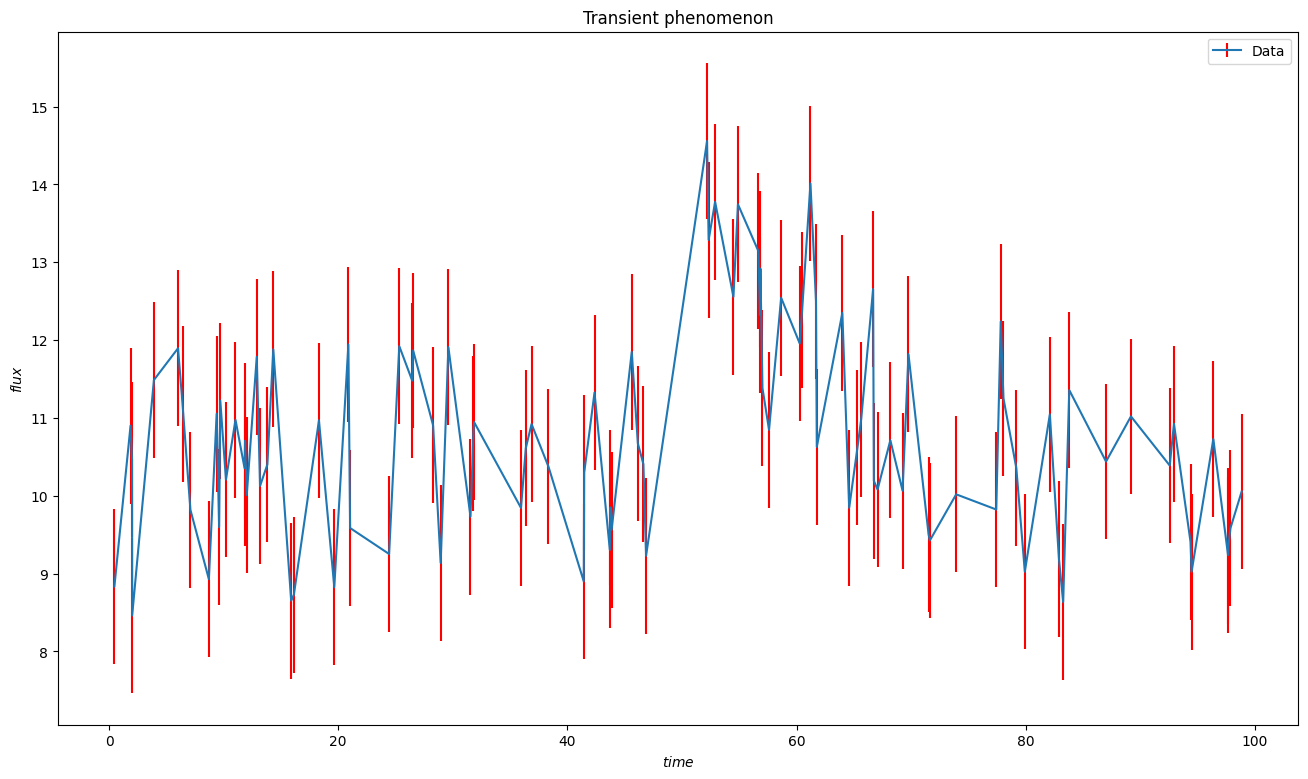

In [4]:
# Plot the data
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Transient phenomenon")
ax.set_xlabel("$time$")
ax.set_ylabel("$flux$")

ax.errorbar(time_data, flux_data, yerr=flux_err_data, ecolor='red', label='Data')

ax.legend()

plt.show()

In [5]:
# Model by eye
t0 = 50
b = 10
A = 5
alpha = 0.1

sigma_w = 10

grid_n_points = 1000

time_grid = np.linspace(np.min(time_data), np.max(time_data), grid_n_points)

flux_burst_model = np.array([burst_model(t, t0, b, A, alpha) for t in time_grid])
flux_gaussian_model = np.array([gaussian_model(t, t0, b, A, sigma_w) for t in time_grid])

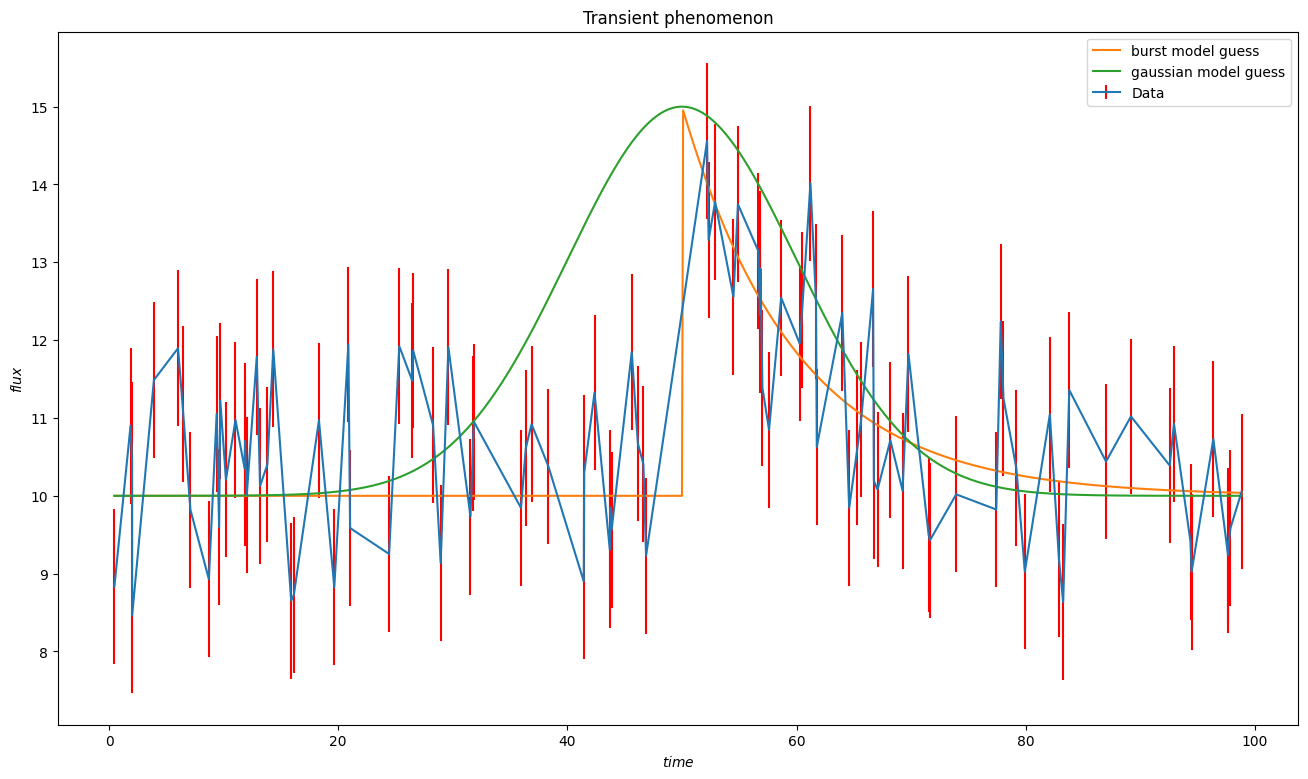

In [6]:
# Plot the guess for the model along with the data
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Transient phenomenon")
ax.set_xlabel("$time$")
ax.set_ylabel("$flux$")

ax.errorbar(time_data, flux_data, yerr=flux_err_data, ecolor='red', label='Data')
ax.plot(time_grid, flux_burst_model, label='burst model guess')
ax.plot(time_grid, flux_gaussian_model, label='gaussian model guess')

ax.legend()

plt.show()

In [7]:
# Define the keys for the models
model_keys = ['burst', 'gaussian']

# Labels for the models
model_title_labels = dict(zip(model_keys, ['Burst model', 'Gaussian model']))

# Define the keys for parameters of the posterior
par_keys = [['A', 'b', 'log_alpha', 't0'], ['A', 'b', 'sigma', 't0']]
par_keys = dict(zip(model_keys, par_keys))

# Associate indexes with a dictionary
par_indexes = dict(zip(model_keys,
                       [dict(zip(par_keys[key],
                                 range(len(par_keys[key]))))
                                 for key in model_keys]))

# Labels and styles for the parameters
par_labels = dict(zip(model_keys, [[] for key in range(len(model_keys))]))
par_u_labels = dict(zip(model_keys, [[] for key in range(len(model_keys))]))
par_colors = dict(zip(model_keys, [[] for key in range(len(model_keys))]))

# Make the parameters labels
for m_key in model_keys:
    for p_key in par_keys[m_key]:
        if p_key == 't0':
            par_labels[m_key].append(r'$t_0$')
            par_u_labels[m_key].append(r'$time$')
            par_colors[m_key].append('lime')
        elif p_key == 'b':
            par_labels[m_key].append(r'$b$')
            par_u_labels[m_key].append(r'$flux$')
            par_colors[m_key].append('orange')
        elif p_key == 'A':
            par_labels[m_key].append(r'$A$')
            par_u_labels[m_key].append(r'$flux$')
            par_colors[m_key].append('royalblue')
        elif p_key == 'log_alpha':
            par_labels[m_key].append(r'$\log(\alpha)$')
            par_u_labels[m_key].append(r'$\log(1/time)$')
            par_colors[m_key].append('rosybrown')
        elif p_key == 'sigma':
            par_labels[m_key].append(r'$\sigma_W$')
            par_u_labels[m_key].append(r'$time$')
            par_colors[m_key].append('rosybrown')

In [8]:
# Define the quantiles to be used for the results (same quantiles for everything)
quantiles = [0.05, 0.5, 0.95]

In [9]:
# Number of dimension of the problem
ndim = 4

# Define our uniform prior via the prior transform.
# u is the unit hypercube from which parameters are initially sampled
def ptform(u, model):
    theta = np.array(u)

    # Choosing a wider parameter space leads to longer sampling times
    # It is better to choose a small prior
    if model == burst_model:
        theta[par_indexes['burst']['t0']] = stats.uniform.ppf(u[par_indexes['burst']['t0']], 40, 60)
        theta[par_indexes['burst']['b']] = stats.uniform.ppf(u[par_indexes['burst']['b']], 0, 20)
        theta[par_indexes['burst']['A']] = stats.uniform.ppf(u[par_indexes['burst']['A']], 0, 20)
        theta[par_indexes['burst']['log_alpha']] = stats.uniform.ppf(u[par_indexes['burst']['log_alpha']], -5, 5)
    # truncnorm() wants the bounding parameters in terms of sigma-distances from loc=mu
    elif model == gaussian_model:
        theta[par_indexes['gaussian']['t0']] = stats.uniform.ppf(u[par_indexes['gaussian']['t0']], 40, 60)
        m, s = 10, 10
        theta[par_indexes['gaussian']['b']] = stats.truncnorm.ppf(u[par_indexes['gaussian']['b']],
                                                                  (0 - m) / s,
                                                                  (20 - m) / s,
                                                                  loc=m, scale=s)
        m, s = 5, 10
        theta[par_indexes['gaussian']['A']] = stats.truncnorm.ppf(u[par_indexes['gaussian']['A']],
                                                                  (0 - m) / s,
                                                                  (20 - m) / s,
                                                                  loc=m, scale=s)
        theta[par_indexes['gaussian']['sigma']] = stats.uniform.ppf(u[par_indexes['gaussian']['sigma']], 1, 20)

    return theta

flux_grid = np.linspace(np.min(flux_data), np.max(flux_data), grid_n_points)

# The loglikelihood of the data given the (sampled) model
# theta is an array of the parameters of the model as transformed by ptform()
# model is a function that accepts parameters in the following order:
# model(t, t0, b, A, alpha or sigma_squared)
def loglike(theta, model):
    if model == burst_model:
        t0 = theta[par_indexes['burst']['t0']]
        b = theta[par_indexes['burst']['b']]
        A = theta[par_indexes['burst']['A']]
        log_alpha = theta[par_indexes['burst']['log_alpha']]

        # Compute the expected flux with the model given by theta at every time
        expected_flux = np.array([model(t, t0, b, A, np.exp(log_alpha)) for t in time_data])
    elif model == gaussian_model:
        t0 = theta[par_indexes['gaussian']['t0']]
        b = theta[par_indexes['gaussian']['b']]
        A = theta[par_indexes['gaussian']['A']]
        sigma_w = theta[par_indexes['gaussian']['sigma']]

        expected_flux = np.array([model(t, t0, b, A, sigma_w) for t in time_data])

    # Compute the loglikelihood of the data assuming a normal distribution around the model
    logL = 0
    for i in range(N):
        logL += np.log(stats.norm.pdf(flux_data[i], expected_flux[i], flux_err))
    
    return logL

In [10]:
# Initialize the sampler
model_arg = {'model': burst_model}
sampler_burst = dynesty.NestedSampler(loglike, ptform, ndim, logl_kwargs=model_arg, ptform_kwargs=model_arg)

In [11]:
model_arg = {'model': gaussian_model}
sampler_gaussian = dynesty.NestedSampler(loglike, ptform, ndim, logl_kwargs=model_arg, ptform_kwargs=model_arg)

In [12]:
# Sample the burst model using nested sampling
sampler_burst.run_nested()

6193it [11:27,  9.01it/s, +500 | bound: 47 | nc: 1 | ncall: 52709 | eff(%): 12.820 | loglstar:   -inf < -140.657 <    inf | logz: -152.247 +/-  0.149 | dlogz:  0.001 >  0.509]


In [13]:
# Sample the gaussian model using nested sampling
sampler_gaussian.run_nested()

0it [00:00, ?it/s]

6692it [09:17, 12.00it/s, +500 | bound: 31 | nc: 1 | ncall: 41428 | eff(%): 17.572 | loglstar:   -inf < -144.331 <    inf | logz: -156.982 +/-  0.159 | dlogz:  0.001 >  0.509]


In [137]:
# Explore the result
burst_sresults = sampler_burst.results

burst_sresults

         nlive: 500
         niter: 6193
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 12.819628799632246
       samples: array([[19.50228585, 17.01764436, -4.94815458, 58.76535617],
       [17.48934671, 18.46321456, -4.59893168, 58.06314163],
       [17.95030884, 18.82105536, -3.4739959 , 49.02323774],
       ...,
       [ 4.16556077, 10.28509967, -2.09859825, 51.63980868],
       [ 4.85714832, 10.28745423, -2.13245932, 49.95670961],
       [ 7.16219227, 10.29024772, -2.11026051, 47.11229686]])
          blob: array([None, None, None, ..., None, None, None], dtype=object)
    samples_id: array([226,  82, 276, ...,  33, 493, 487])
    samples_it: array([   0,    0,    0, ..., 5681, 5919, 6068])
     samples_u: array([[0.97511429, 0.85088222, 0.01036908, 0.31275594],
       [0.87446734, 0.92316073, 0.08021366, 0.30105236],
       [0.89751544, 0.94105277, 0.30520082, 0.1503873 ],
       ...,
       [0.20827804, 0.51425498, 0.58028035, 0.19399681],
       [0.24285742, 0.5

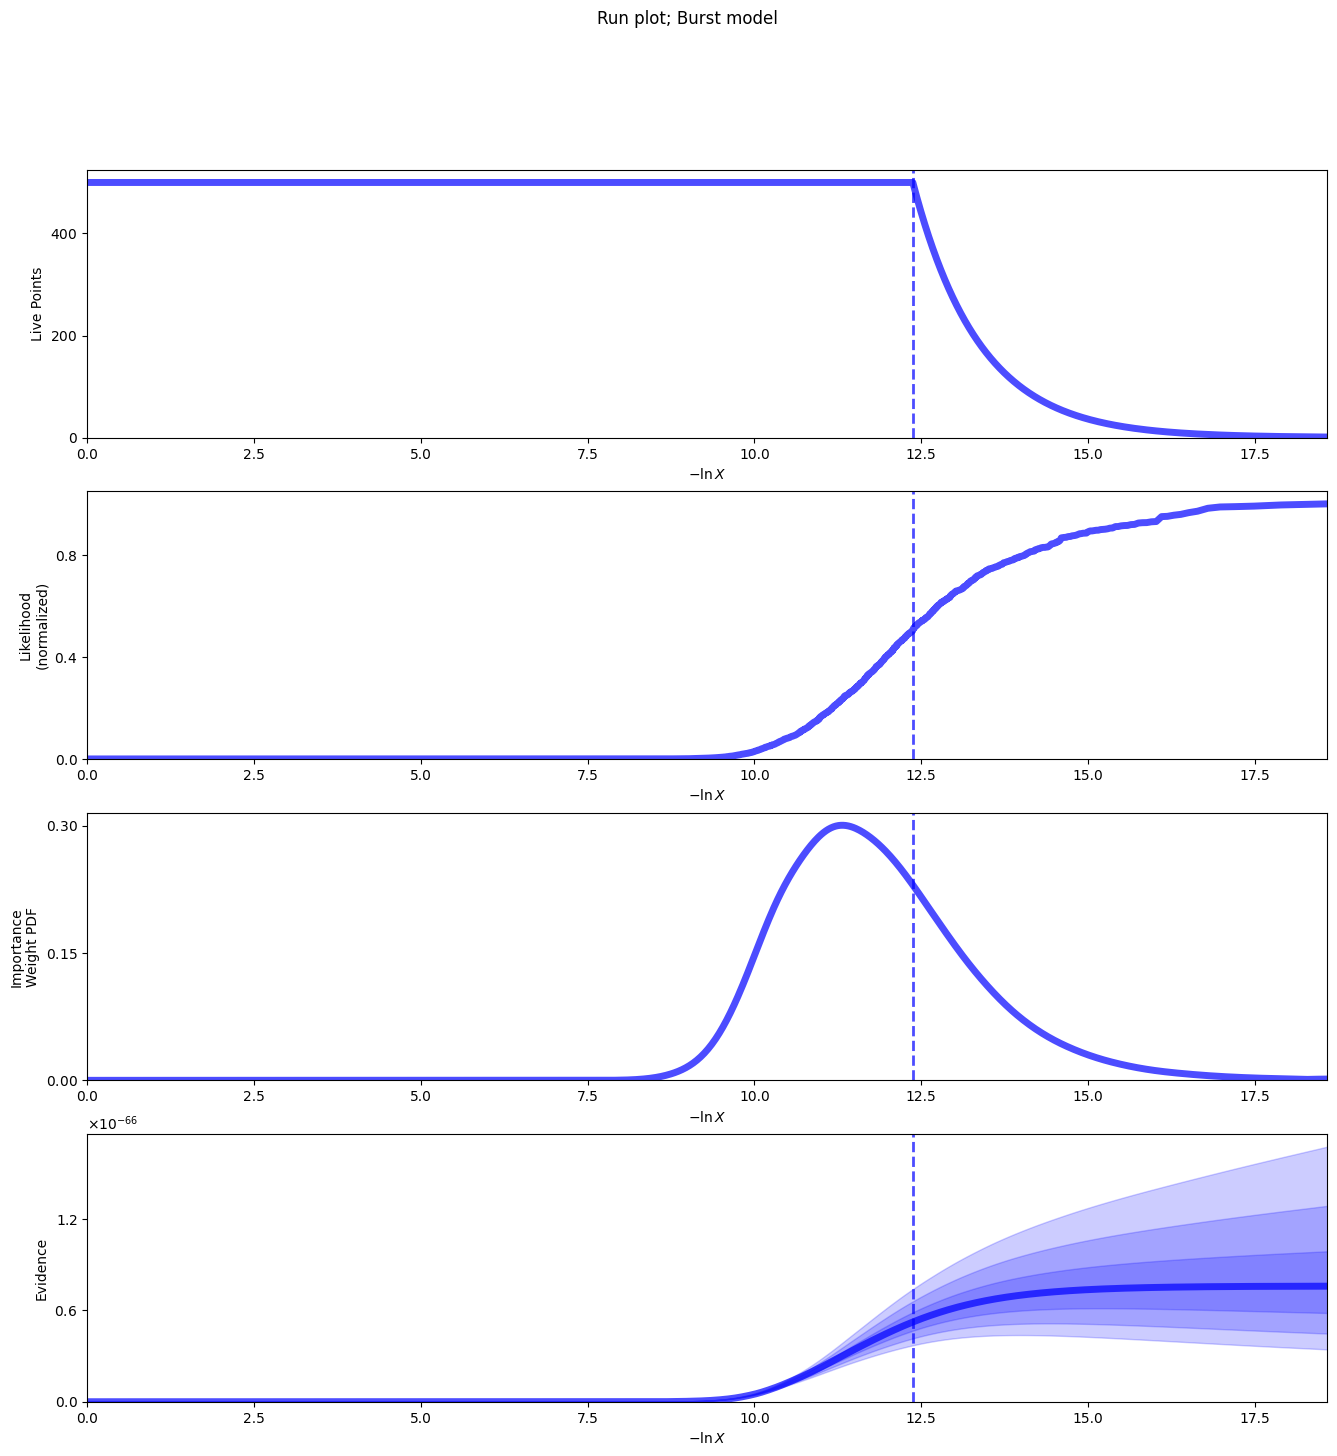

In [138]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(burst_sresults)

rfig.suptitle("Run plot; " + model_title_labels['burst'])

plt.show()

# Note

Be aware of the fact that samples in nested **sampling** by *dynesty* are **_weighted_**, therefore using plotting functions from different libraries (e.g. ArviZ) would result in wrong quantiles computations.

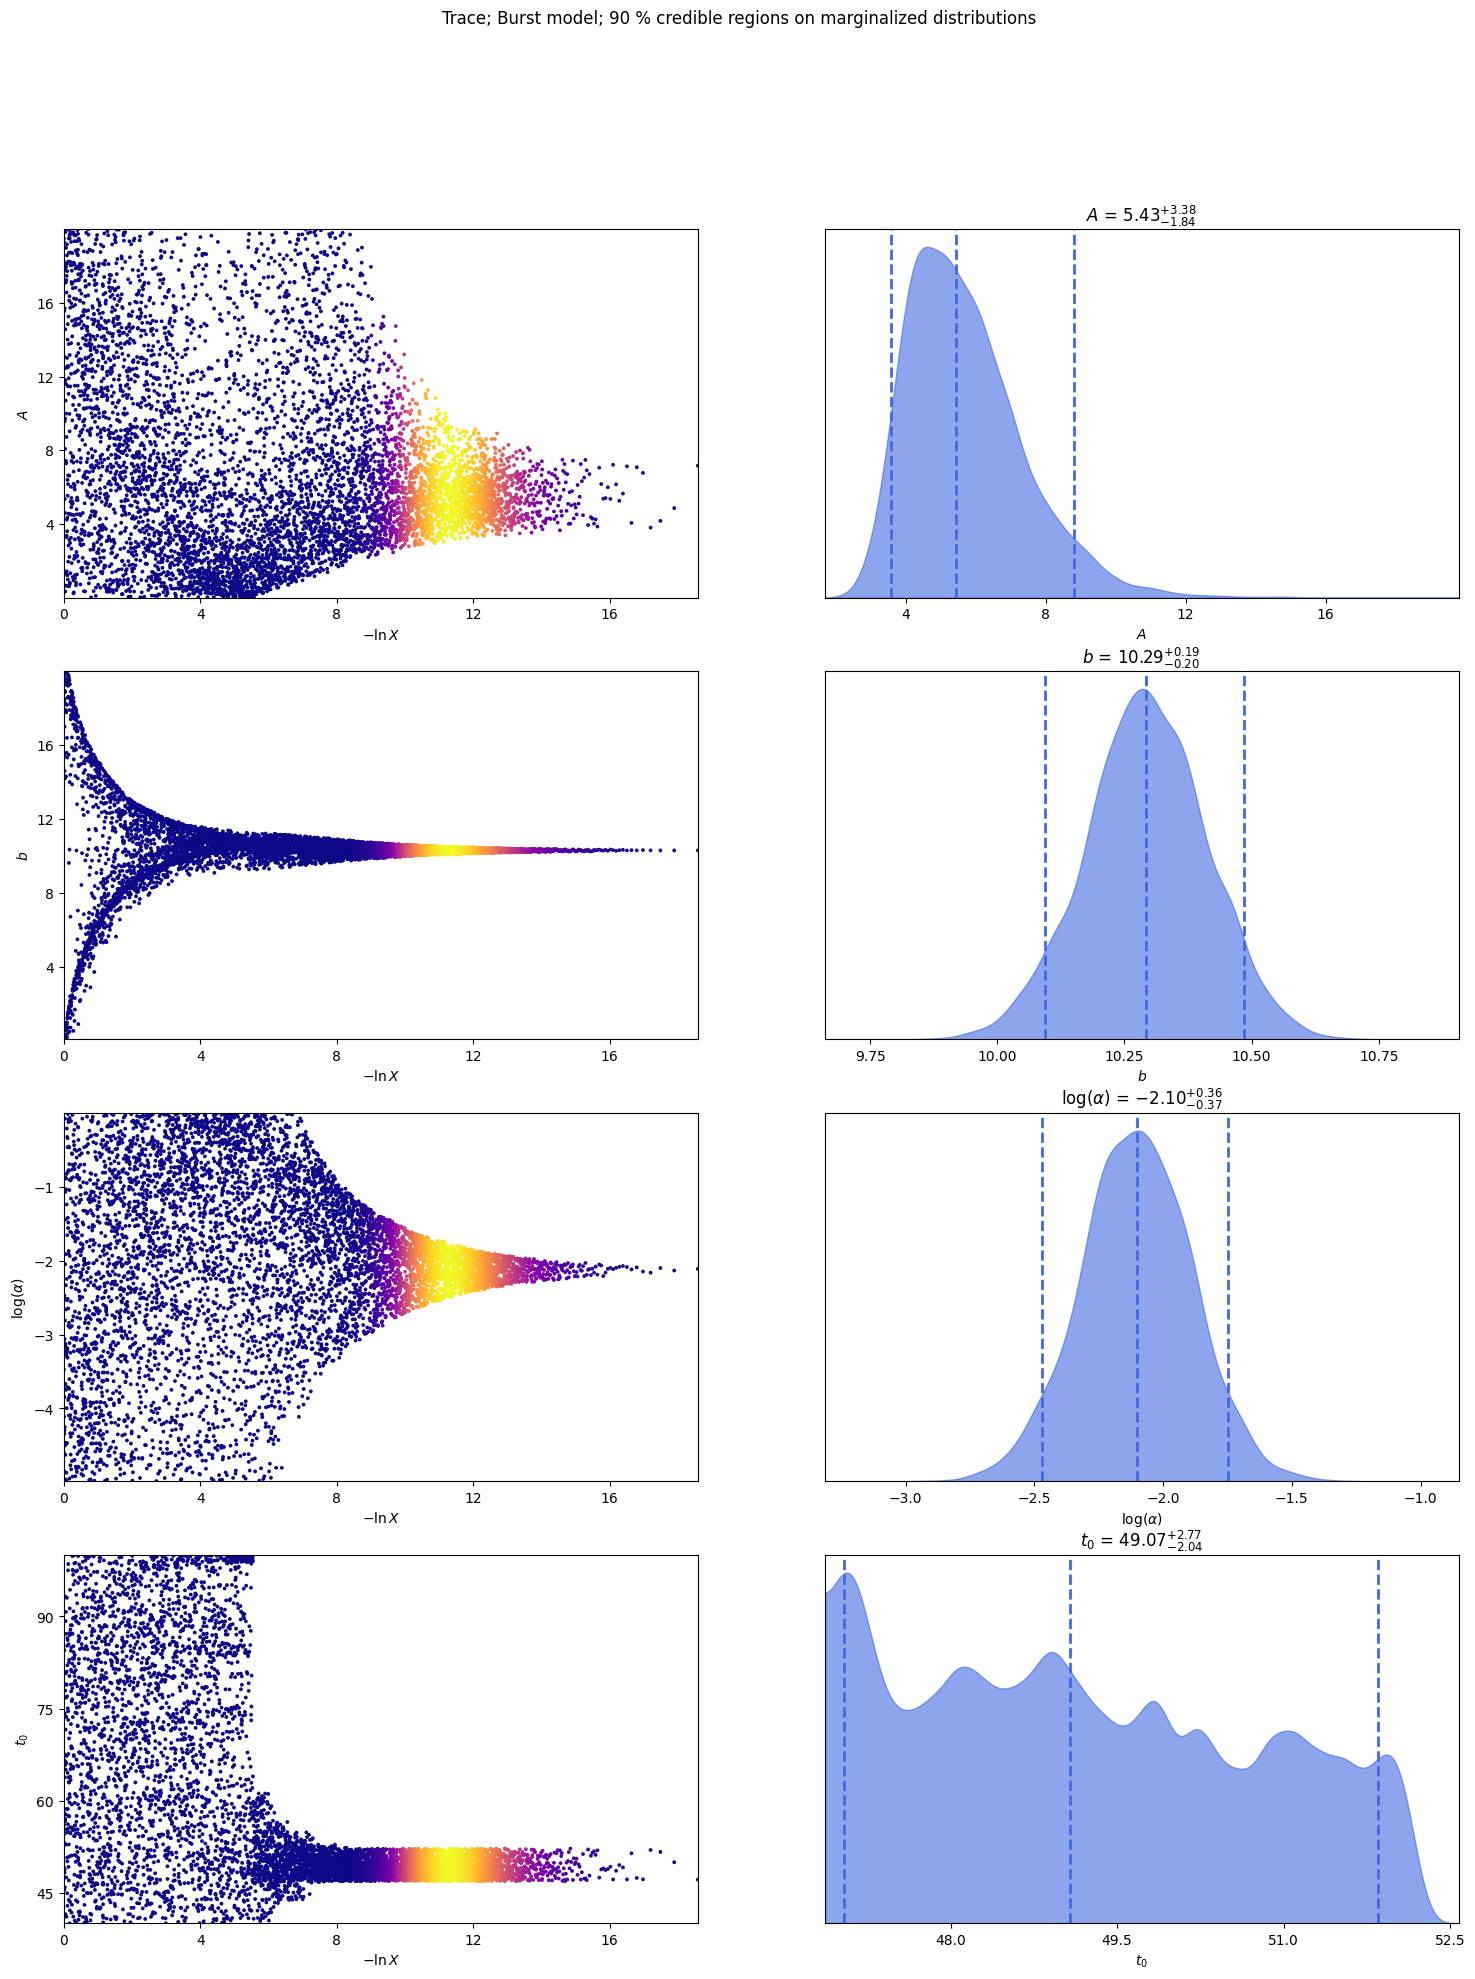

In [139]:
# Trace plot
tfig, taxes = dyplot.traceplot(burst_sresults,
                               labels=par_labels['burst'],
                               show_titles=True,
                               quantiles=quantiles,
                               title_quantiles=quantiles,
                               post_color='royalblue')

tfig.set_size_inches(18, 22)
tfig.suptitle("Trace; " +
              model_title_labels['burst'] +
              "; 90 % credible regions on marginalized distributions")

plt.show()

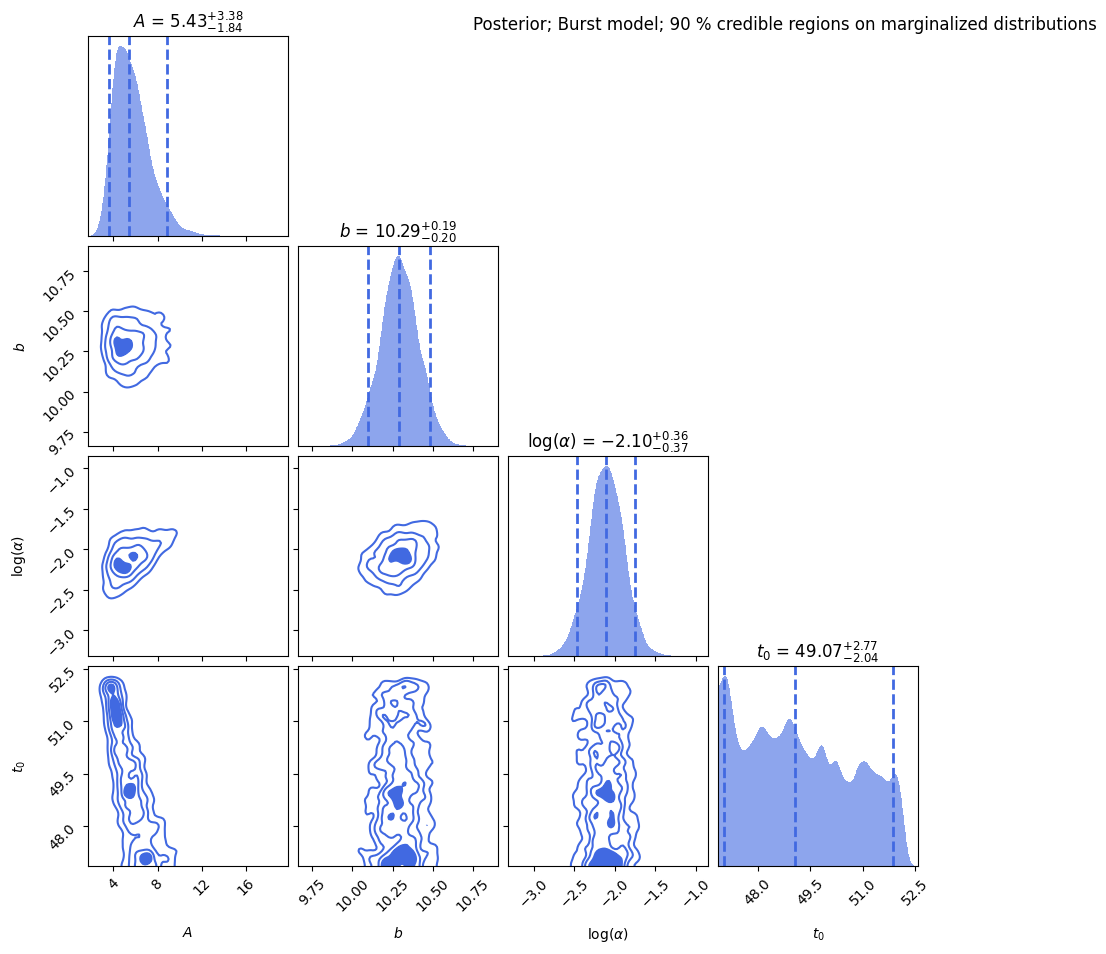

In [140]:
# Corner plot
cfig, caxes = dyplot.cornerplot(burst_sresults,
                                labels=par_labels['burst'],
                                show_titles=True,
                                color='royalblue',
                                quantiles=quantiles,
                                title_quantiles=quantiles)

cfig.suptitle("Posterior; " +
              model_title_labels['burst'] +
              "; 90 % credible regions on marginalized distributions", horizontalalignment='left')

plt.show()

In [141]:
gaussian_sresults = sampler_gaussian.results

gaussian_sresults

         nlive: 500
         niter: 6692
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 17.572322126661454
       samples: array([[19.71176215, 18.28438937, 16.28352621, 53.32489273],
       [17.21854834, 18.52273999, 20.12693907, 71.01373874],
       [17.98988136, 19.56723827, 14.23425895, 64.50409446],
       ...,
       [ 2.77638749, 10.30934013,  5.47596887, 55.62879883],
       [ 2.68958767, 10.303117  ,  5.40045935, 55.35539696],
       [ 2.73385712, 10.3076473 ,  5.27157844, 55.64608887]])
          blob: array([None, None, None, ..., None, None, None], dtype=object)
    samples_id: array([ 98, 118,   6, ...,  98, 242, 326])
    samples_it: array([   0,    0,    0, ..., 6654, 6557, 5833])
     samples_u: array([[0.99389338, 0.93400261, 0.76417631, 0.22208155],
       [0.92944258, 0.94378738, 0.95634695, 0.51689565],
       [0.95170648, 0.98432951, 0.66171295, 0.40840157],
       ...,
       [0.16565745, 0.51807398, 0.22379844, 0.26047998],
       [0.16025455, 0.5

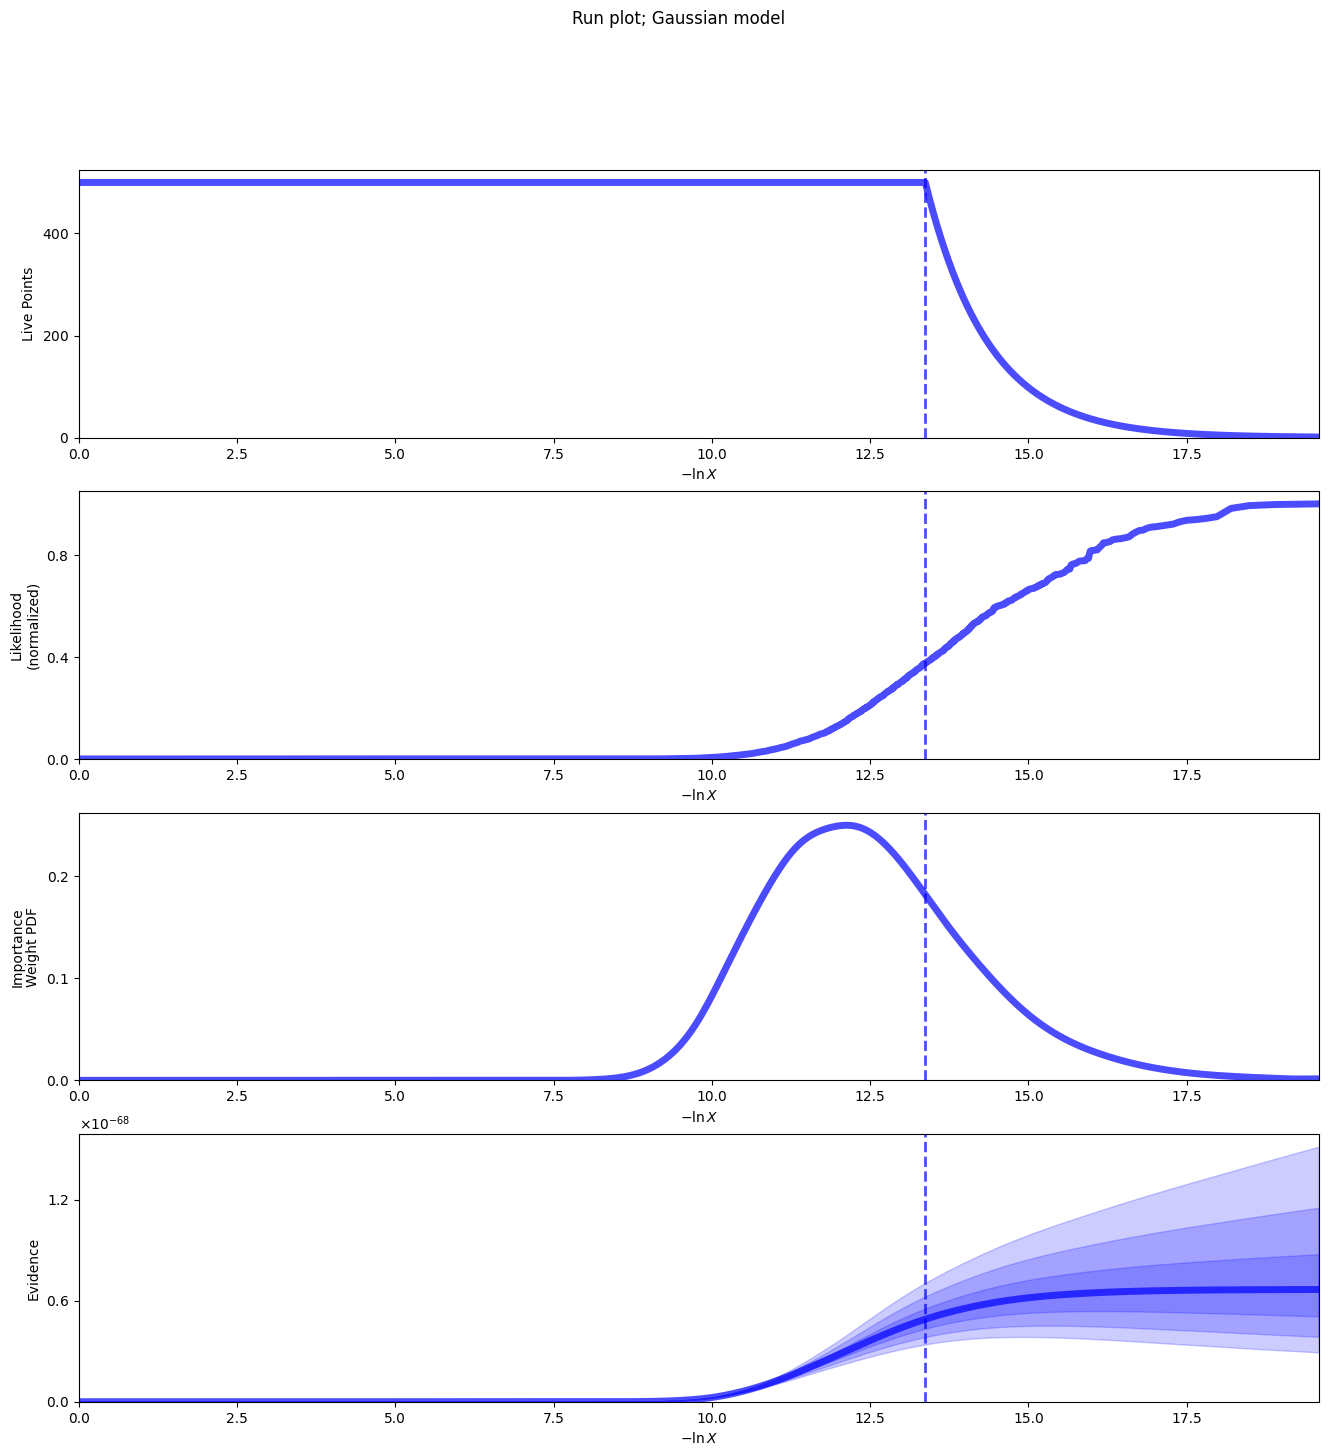

In [142]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(gaussian_sresults)

rfig.suptitle("Run plot; " + model_title_labels['gaussian'])

plt.show()

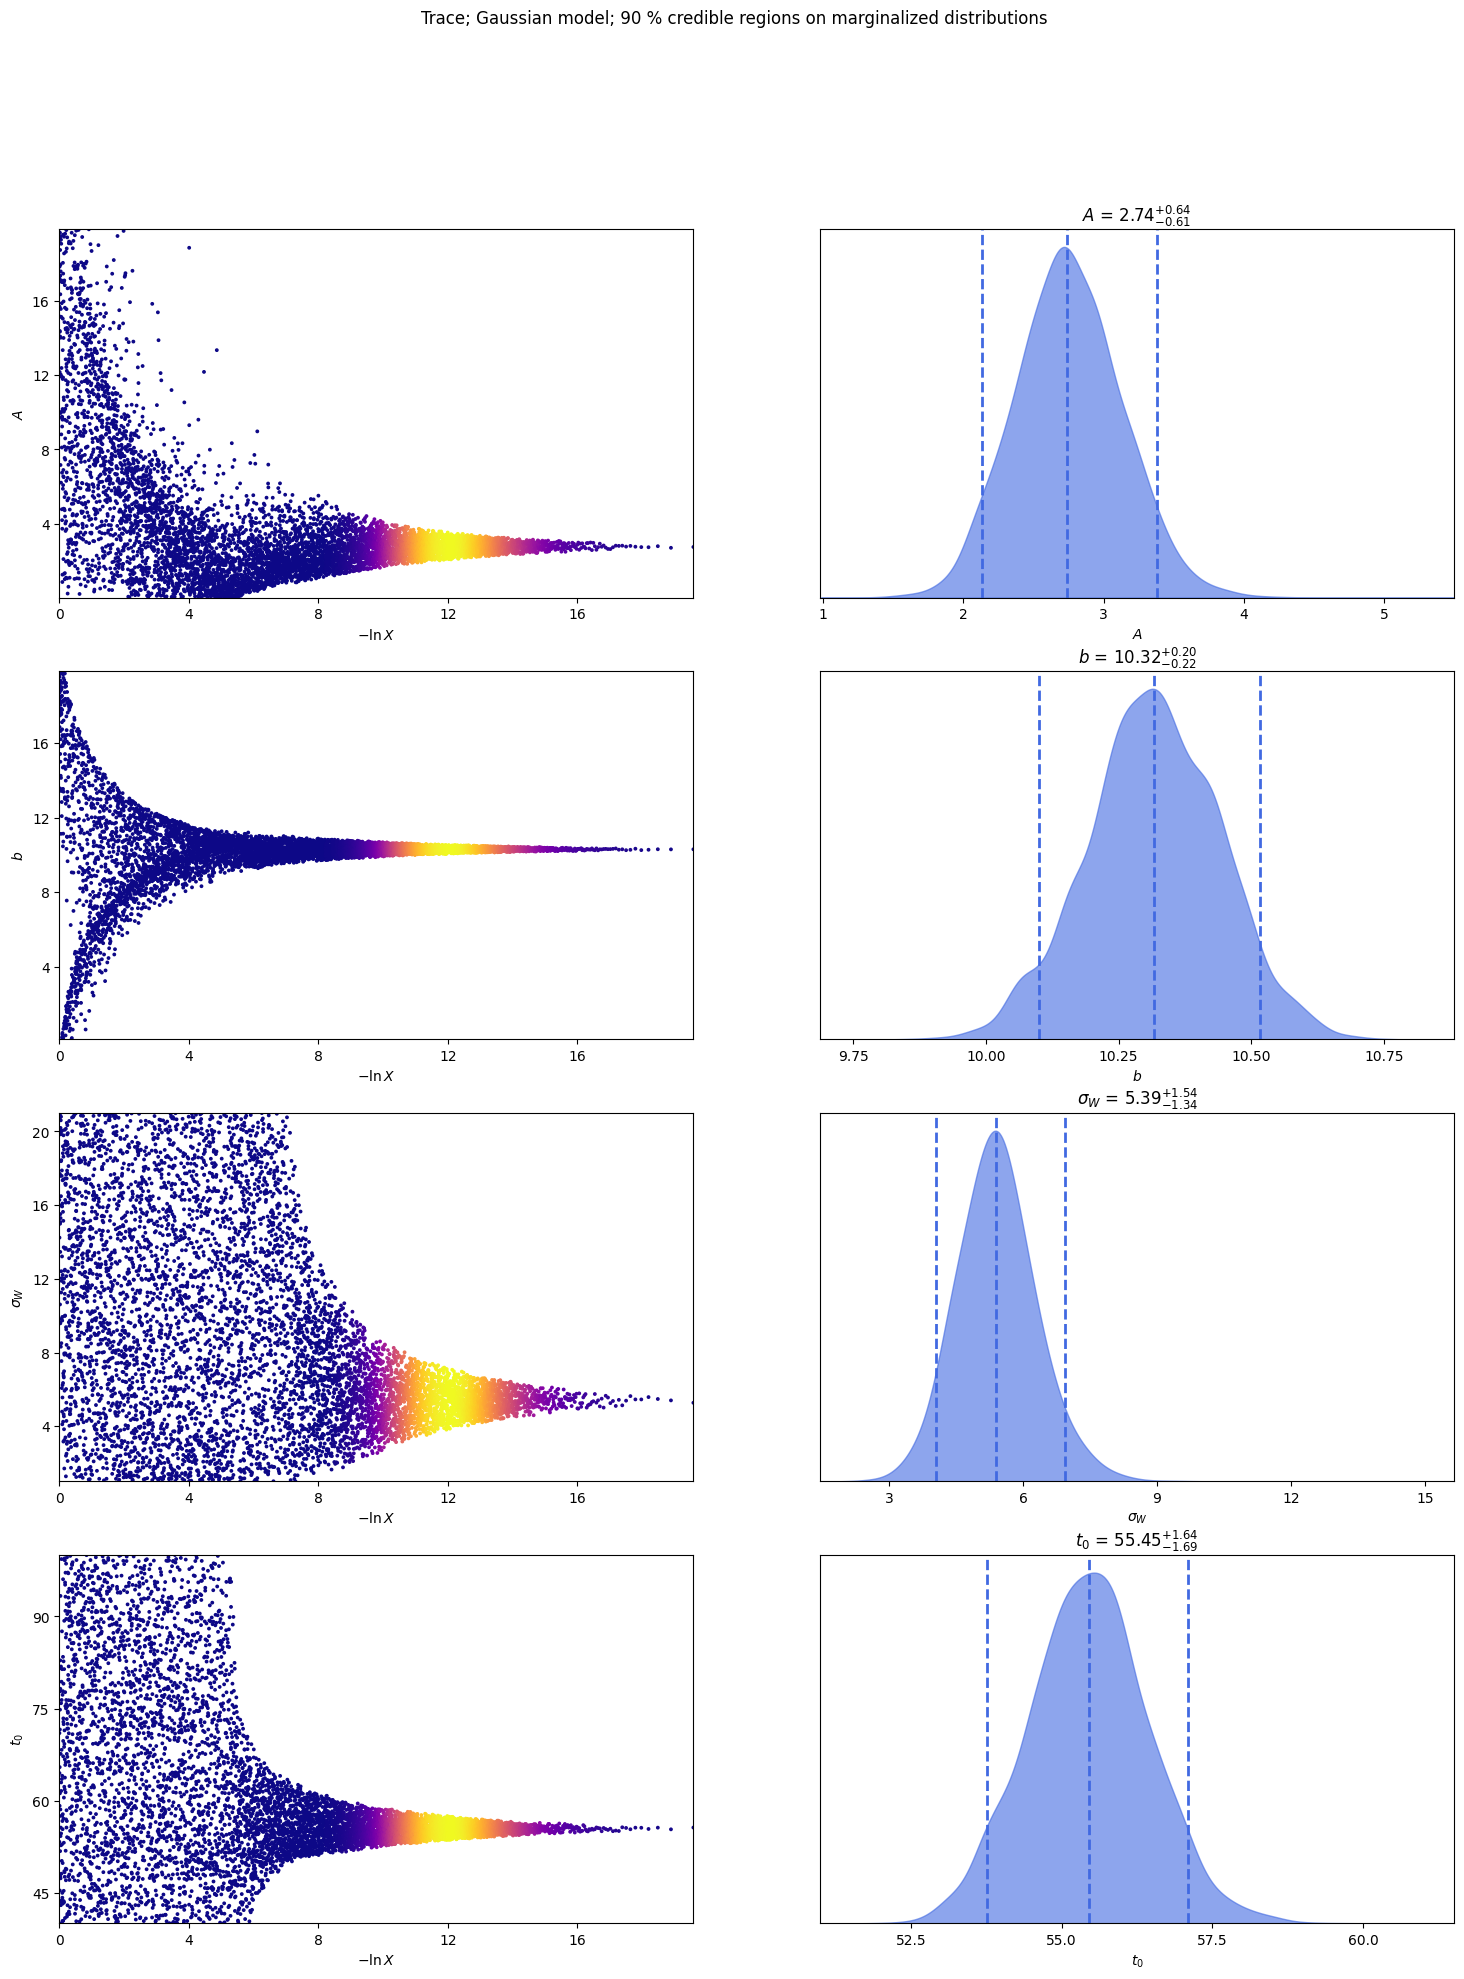

In [143]:
# Trace plot
tfig, taxes = dyplot.traceplot(gaussian_sresults,
                               labels=par_labels['gaussian'],
                               show_titles=True,
                               quantiles=quantiles,
                               title_quantiles=quantiles,
                               post_color='royalblue')

tfig.set_size_inches(18, 22)
tfig.suptitle("Trace; " +
              model_title_labels['gaussian'] +
              "; 90 % credible regions on marginalized distributions")

plt.show()

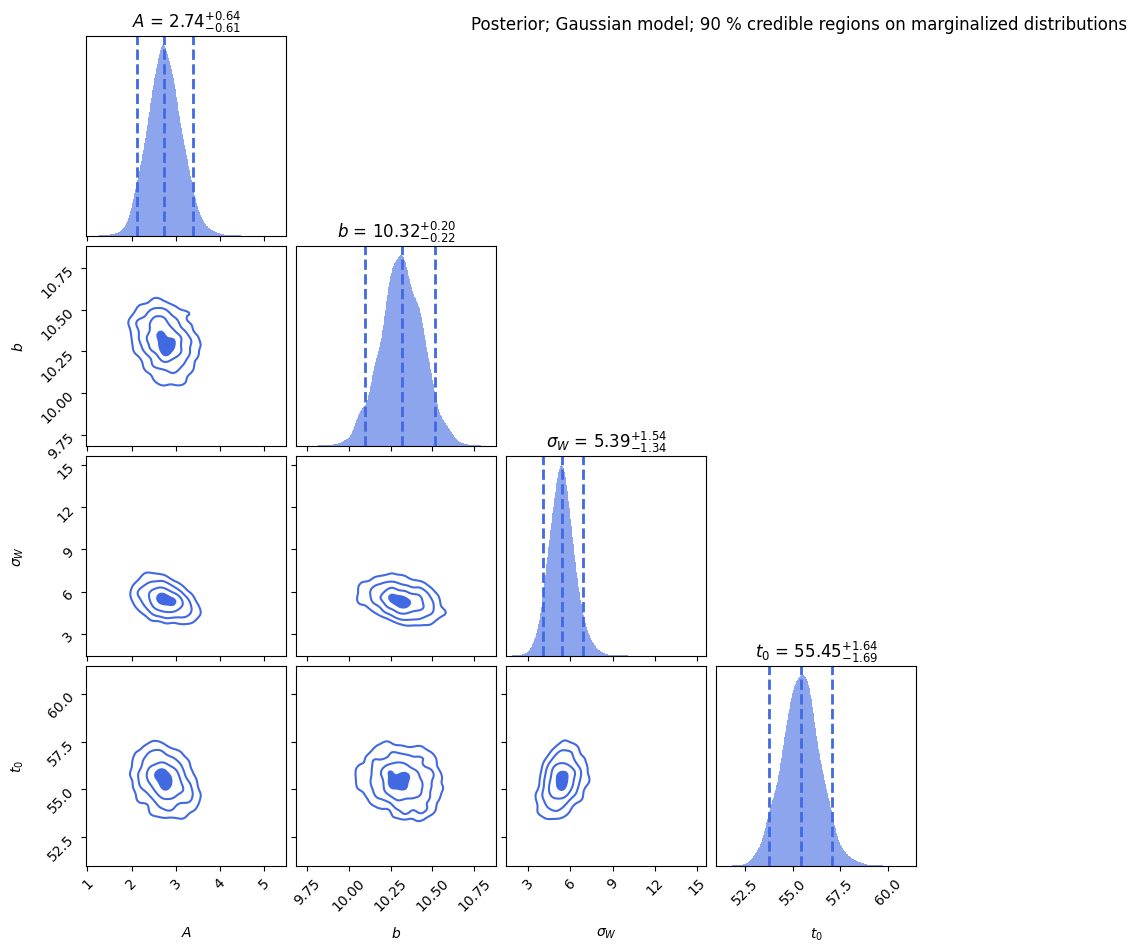

In [144]:
# Corner plot
cfig, caxes = dyplot.cornerplot(gaussian_sresults,
                                labels=par_labels['gaussian'],
                                show_titles=True,
                                color='royalblue',
                                quantiles=quantiles,
                                title_quantiles=quantiles)

cfig.suptitle("Posterior; " +
              model_title_labels['gaussian'] +
              "; 90 % credible regions on marginalized distributions", horizontalalignment='left')

plt.show()

In [145]:
# Put together the results in a dictionary
sresults = dict(zip(model_keys, [burst_sresults, gaussian_sresults]))

In [146]:
# Burn index of the chains
burn_index = dict(zip(model_keys, [4000, 4000]))

# Once you acces the samples, sresults works like this: sresults[sample_index][par_index]
# par_pos[model_key][par_index][sample_index]
par_pos = dict(zip(model_keys,
                   [np.swapaxes(sresults[key]['samples'][burn_index[key]:], 0, 1)
                    for key in model_keys]))

In [147]:
# Styles for the quantiles
quantile_styles = [':', '-.', '--']
quantile_colors = ['magenta', 'red', 'magenta']
quantile_labels = [str(int(quantiles[0] * 100)) + ' % quantile',
                   r'$\mu$',
                   str(int(quantiles[2] * 100)) + ' % quantile']

# Save the quantiles of the parameters
par_quantiles = dict(zip(model_keys, [[] for key in range(len(model_keys))]))

# 90 % credible regions. Note that we need the weights of the samples
for m_key in model_keys:
    for p_key in par_keys[m_key]:
        sample_weights = sresults[m_key].importance_weights()[burn_index[m_key]:]
        par_quantiles[m_key].append(dynesty.utils.quantile(par_pos[m_key][par_indexes[m_key][p_key]],
                                                           quantiles,
                                                           sample_weights))
    par_quantiles[m_key] = np.array(par_quantiles[m_key])

# Construct the result for every model and parameter using the quantiles
par_values_str = dict(zip(model_keys, [[] for key in range(len(model_keys))]))

for m_key in model_keys:
    for p_key in par_keys[m_key]:
        l_ = np.format_float_positional(par_quantiles[m_key][par_indexes[m_key][p_key]][1] -
                                        par_quantiles[m_key][par_indexes[m_key][p_key]][0], 2)
        mu = np.format_float_positional(par_quantiles[m_key][par_indexes[m_key][p_key]][1], 2)
        _r = np.format_float_positional(par_quantiles[m_key][par_indexes[m_key][p_key]][2] -
                                        par_quantiles[m_key][par_indexes[m_key][p_key]][1], 2)

        # To escape the '{' and the '}' you have to use {{ and }}
        par_values_str[m_key].append(r'${mu}^{{+{_r}}}_{{-{l_}}}$'.format(mu=mu, _r=_r, l_=l_))

In [148]:
# Function to plot the marginalized distribution with 90 % credible regions
# for each paramter for the specified model
def plot_marginalized_dist(model_key):
    n_rows = 2
    n_cols = 2

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(20,12))

    fig.suptitle("Posterior; " +
                 model_title_labels[model_key] +
                 "; 90 % credible regions on marginalized distributions")

    index = 0
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i][j].set_title(par_labels[model_key][index] + r'$=$' + par_values_str[model_key][index])
            ax[i][j].set_xlabel(par_u_labels[model_key][index])
            ax[i][j].set_ylabel(r'$probability$')

            ax[i][j].hist(par_pos[model_key][index],
                          bins='auto',
                          density=True,
                          color=par_colors[model_key][index],
                          histtype='step')
            
            # Quantile lines plotting
            for k in range(len(par_quantiles[model_key][index])):
                ax[i][j].axvline(par_quantiles[model_key][index][k],
                                color=quantile_colors[k],
                                ls=quantile_styles[k],
                                label=quantile_labels[k])

            ax[i][j].legend()
            
            index += 1

    plt.show()

In [149]:
# Function to plot a ceratin number of random sampled models from the posterior
def plot_random_sampled_models(model_key, n_sample):
    # Select n_sample random samples (in 2 steps to make it readable)
    rnd_samples = sresults[model_key]['samples'][burn_index[model_key]:]
    rnd_samples = rnd_samples[np.random.randint(0,
                                                len(sresults[model_key]['samples'][burn_index[model_key]:]),
                                                n_sample)]
    
    if model_key == 'burst':
        models = np.array([[burst_model(t,
                                        rnd_samples[i][par_indexes[model_key]['t0']],
                                        rnd_samples[i][par_indexes[model_key]['b']],
                                        rnd_samples[i][par_indexes[model_key]['A']],
                                        np.exp(rnd_samples[i]
                                               [par_indexes[model_key]['log_alpha']]))
                                        for t in time_grid]
                                        for i in range(len(rnd_samples))])
        
        # Build the bast model
        best_model = np.array([burst_model(t,
                                           par_quantiles[model_key][par_indexes[model_key]['t0']][1],
                                           par_quantiles[model_key][par_indexes[model_key]['b']][1],
                                           par_quantiles[model_key][par_indexes[model_key]['A']][1],
                                           np.exp(par_quantiles[model_key]
                                                  [par_indexes[model_key]['log_alpha']][1]))
                                           for t in time_grid])
    elif model_key == 'gaussian':
        models = np.array([[gaussian_model(t,
                                           rnd_samples[i][par_indexes[model_key]['t0']],
                                           rnd_samples[i][par_indexes[model_key]['b']],
                                           rnd_samples[i][par_indexes[model_key]['A']],
                                           np.sqrt(rnd_samples[i]
                                                   [par_indexes[model_key]['sigma']]))
                                           for t in time_grid]
                                           for i in range(len(rnd_samples))])
        
        # Build the bast model
        best_model = np.array([gaussian_model(t,
                                              par_quantiles[model_key][par_indexes[model_key]['t0']][1],
                                              par_quantiles[model_key][par_indexes[model_key]['b']][1],
                                              par_quantiles[model_key][par_indexes[model_key]['A']][1],
                                              np.sqrt(par_quantiles[model_key]
                                                      [par_indexes[model_key]['sigma']][1]))
                                              for t in time_grid])
        
    # Plot the models from the randomly selected samples
    fig, ax = plt.subplots(figsize=(16,9))

    ax.set_title("Transient phenomenon; " + model_title_labels[model_key])
    ax.set_xlabel("$time$")
    ax.set_ylabel("$flux$")

    ax.errorbar(time_data, flux_data, yerr=flux_err_data, ecolor='red', label='Data')

    # Random selected models
    for i in range(len(models)):
        ax.plot(time_grid, models[i], alpha=0.25) # alpha is to set the opacity

    # Best model
    ax.plot(time_grid, best_model, color='black', label='(not) Best model', ls='-.')

    ax.legend()

    plt.show()

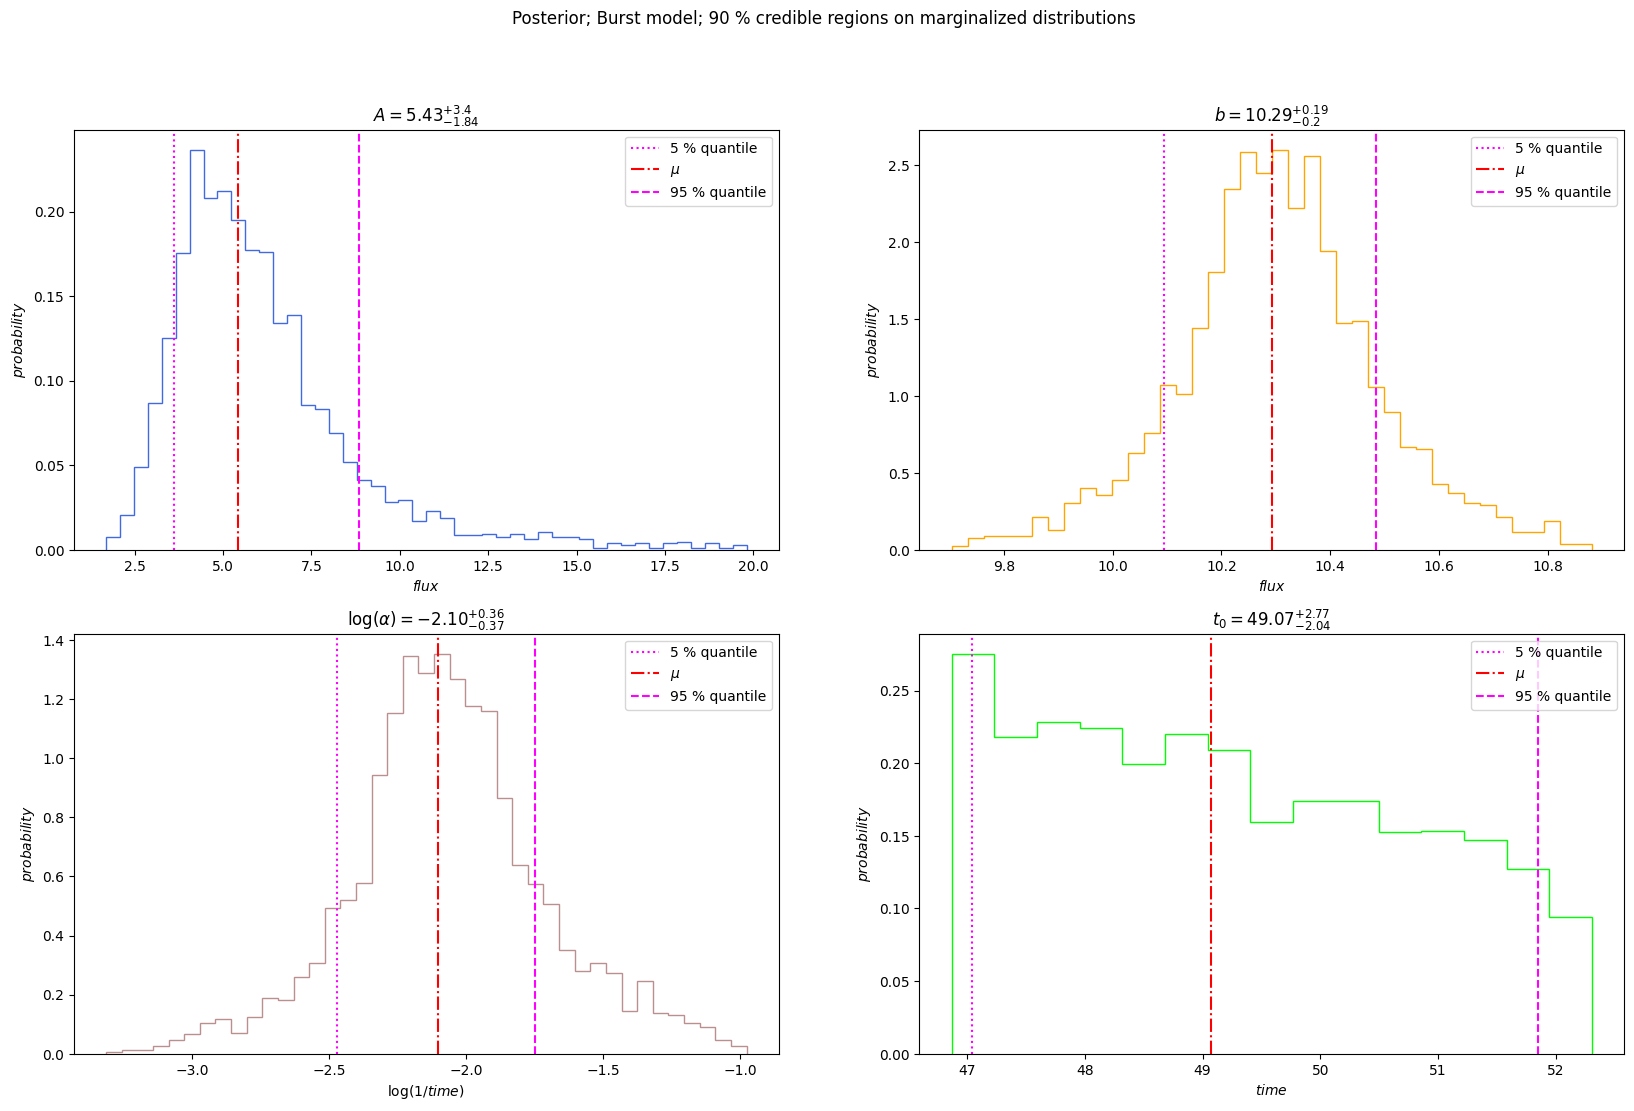

In [150]:
plot_marginalized_dist('burst')

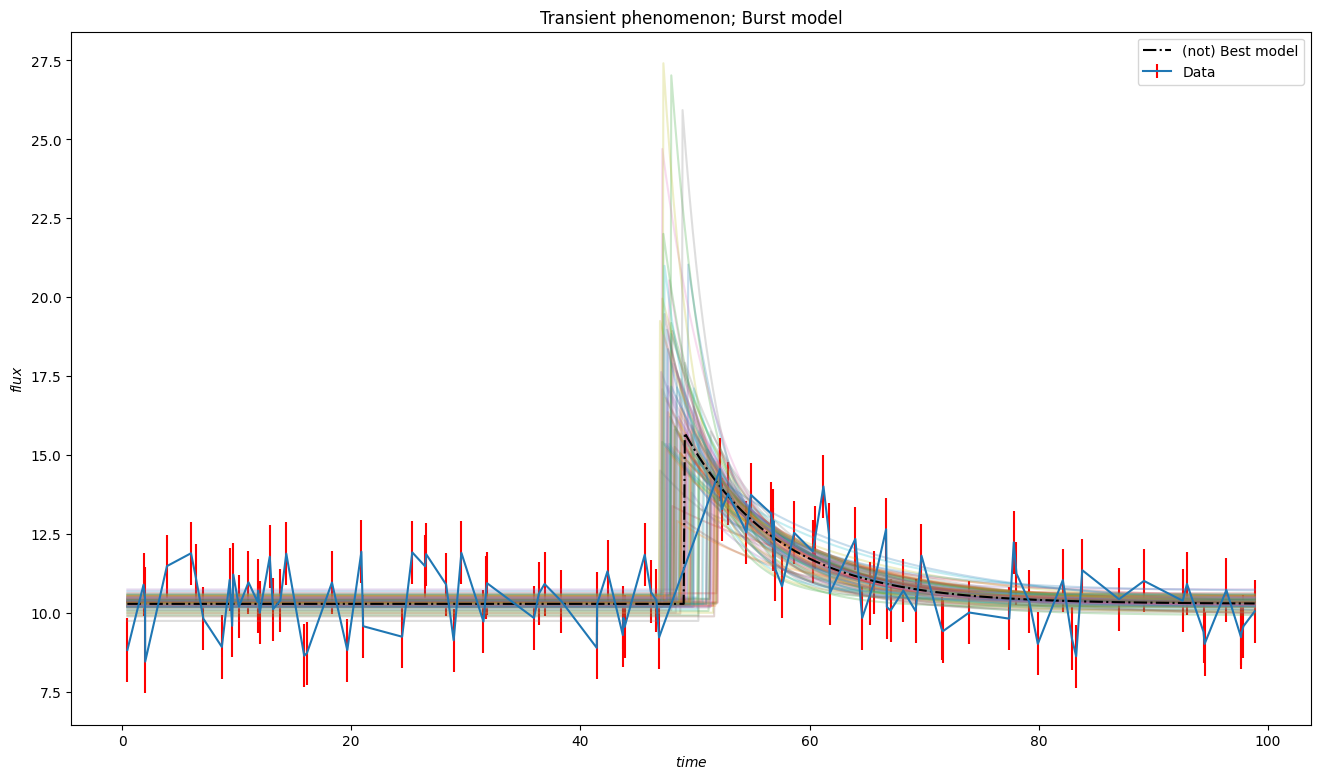

In [151]:
plot_random_sampled_models('burst', 100)

# Check L11 exercise note about the **_(not) Best model_**

At the end of the notebook

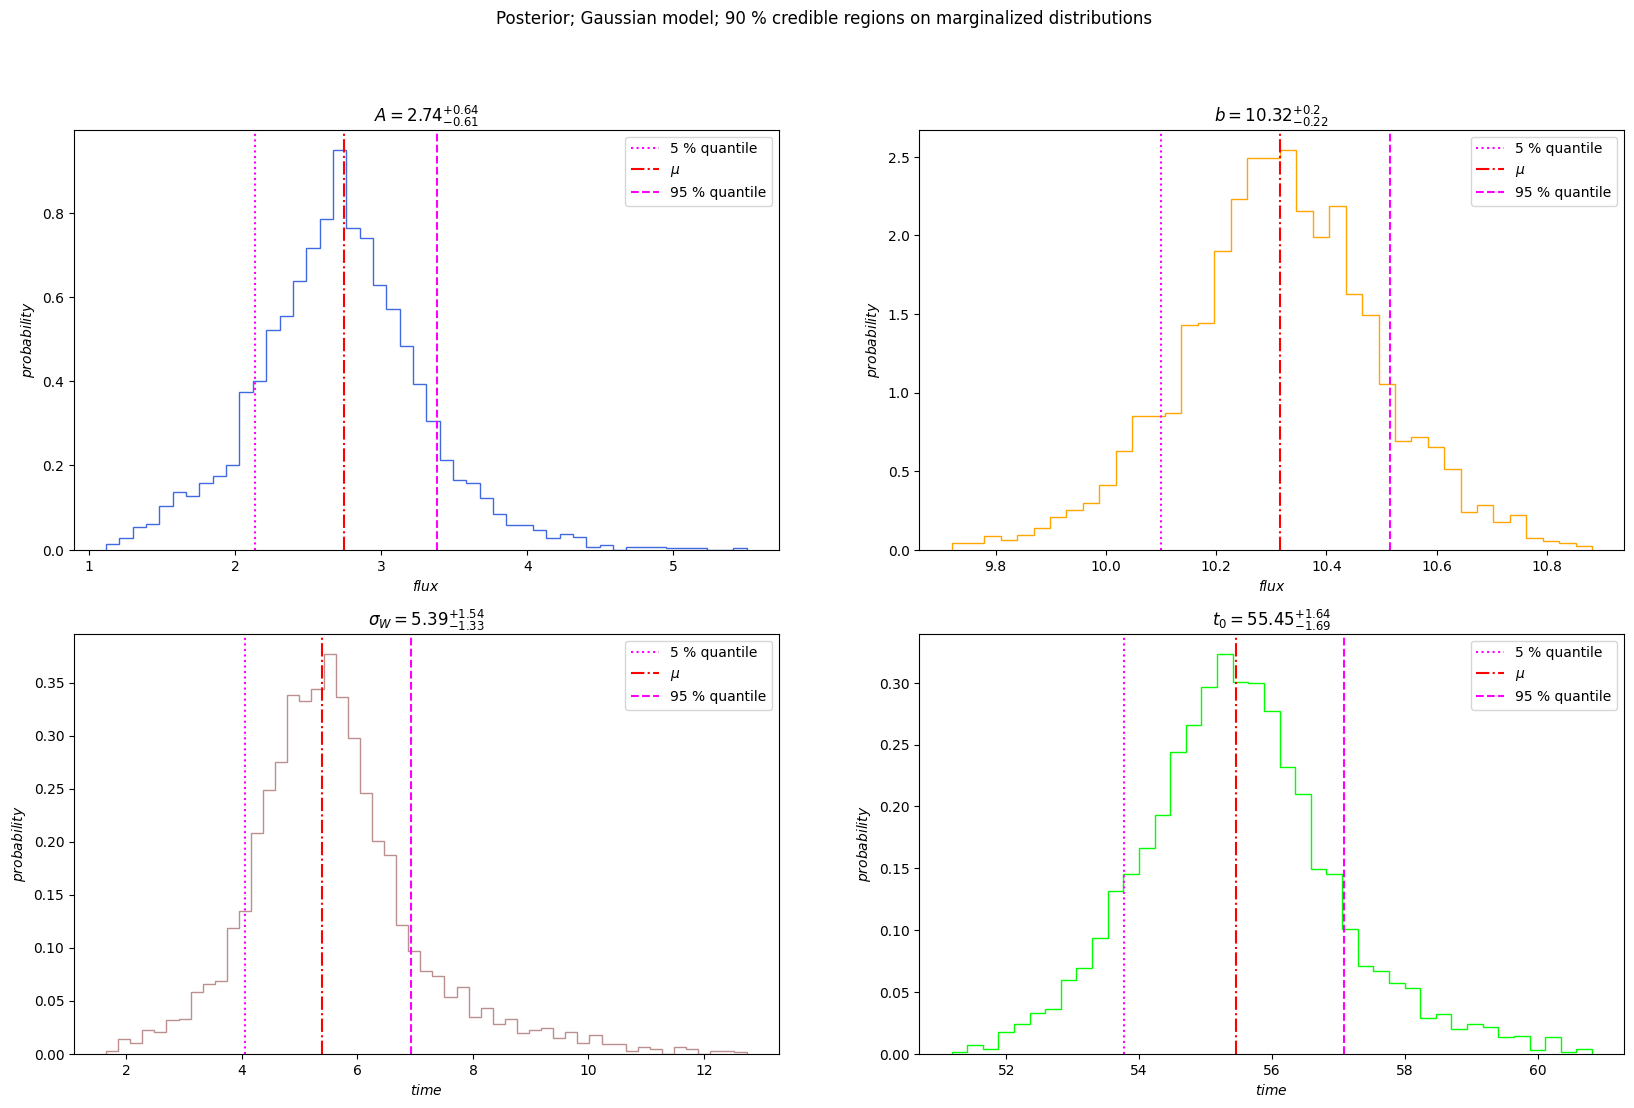

In [152]:
plot_marginalized_dist('gaussian')

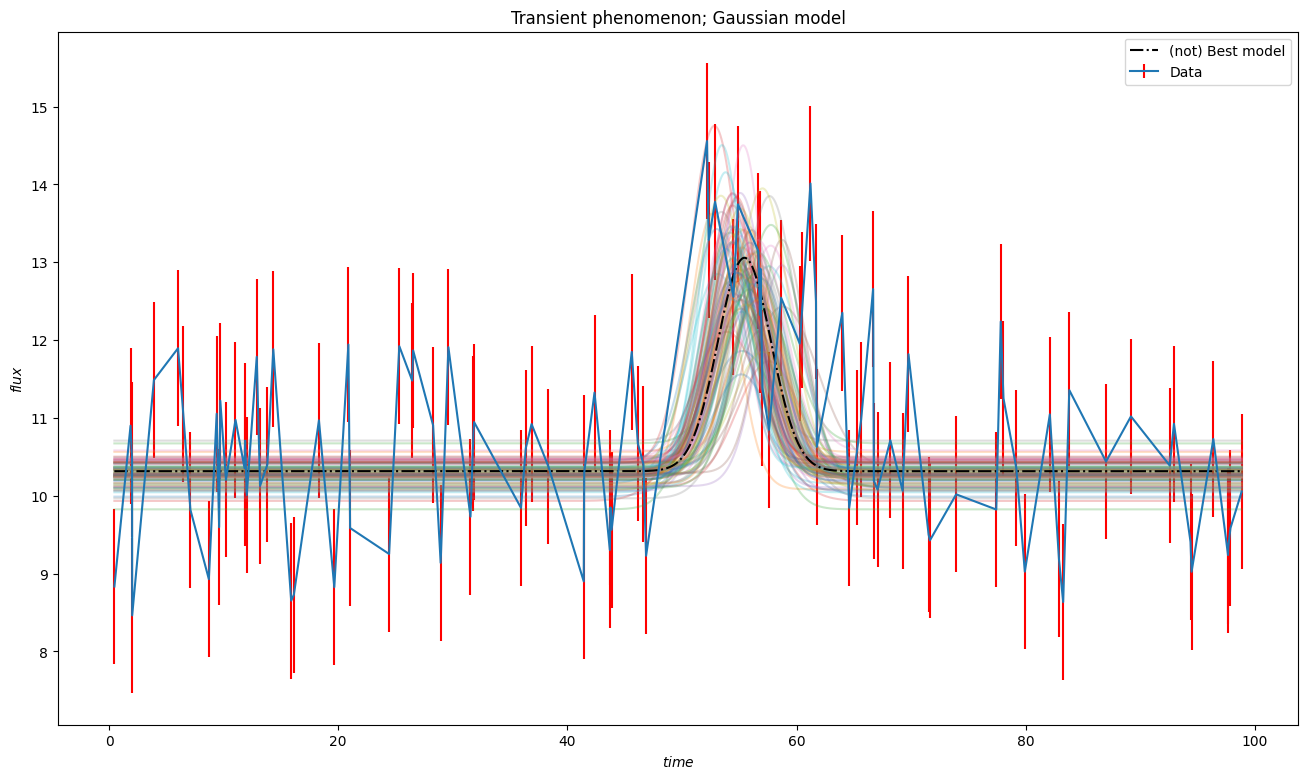

In [153]:
plot_random_sampled_models('gaussian', 100)

In [154]:
# Compute the logarithm of the bayes factor using the evidences
log_Bayes_factor_burst_vs_gaussian = sresults['burst']['logz'][-1] - sresults['gaussian']['logz'][-1]

print("log(Bayes factor) = " + str(log_Bayes_factor_burst_vs_gaussian))

log(Bayes factor) = 4.735359020227861


# Check **L09 - Bayesian Model Comparison**
There is **_DECISIVE_** evidence in favor of the **Burst** model rather than the **~~Gaussian~~** model

Note that I _didn't normalized_ the _likelihoods_ and therefore the evidences alone are incorrect, however their ratio is correct (because the likelihoods are both gaussian).